### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Importing Machine Learning and Other Required libraries

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, auc, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

### Download NLTK resources

In [17]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Set style for plots

In [4]:
plt.style.use('ggplot')
sns.set_palette("husl")

## 1. Data Exploration and Preparation

### Load the dataset

In [5]:
df = pd.read_csv('twitter_disaster (1).csv')

### Display basic information about the dataset

In [6]:
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (7613, 5)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

First 5 rows:
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3    

### Check for missing values

In [7]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


### Handle Missing values

In [8]:
df['keyword'].fillna('unknown', inplace=True)
df['location'].fillna('unknown', inplace=True)

### Check the distribution of target variable

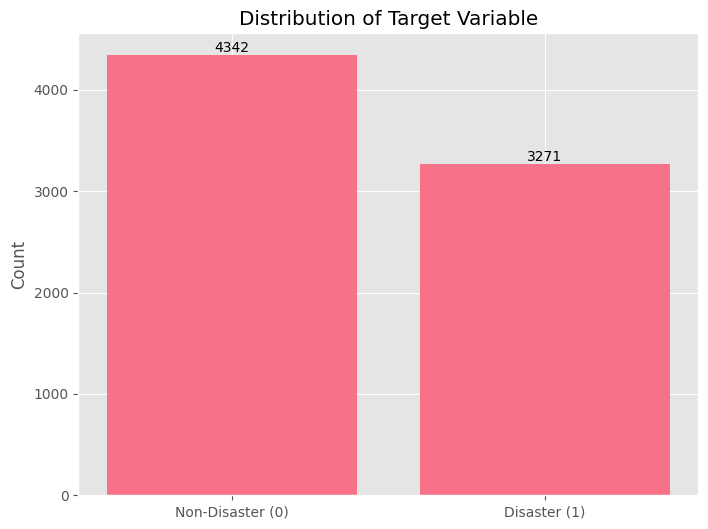

Disaster tweets: 3271 (42.97%)
Non-disaster tweets: 4342 (57.03%)


In [9]:
plt.figure(figsize=(8, 6))
target_counts = df['target'].value_counts()
plt.bar(['Non-Disaster (0)', 'Disaster (1)'], target_counts.values)
plt.title('Distribution of Target Variable')
plt.ylabel('Count')
plt.text(0, target_counts[0], str(target_counts[0]), ha='center', va='bottom')
plt.text(1, target_counts[1], str(target_counts[1]), ha='center', va='bottom')
plt.show()

print(f"Disaster tweets: {target_counts[1]} ({target_counts[1]/len(df)*100:.2f}%)")
print(f"Non-disaster tweets: {target_counts[0]} ({target_counts[0]/len(df)*100:.2f}%)")

### Analyze text length distribution

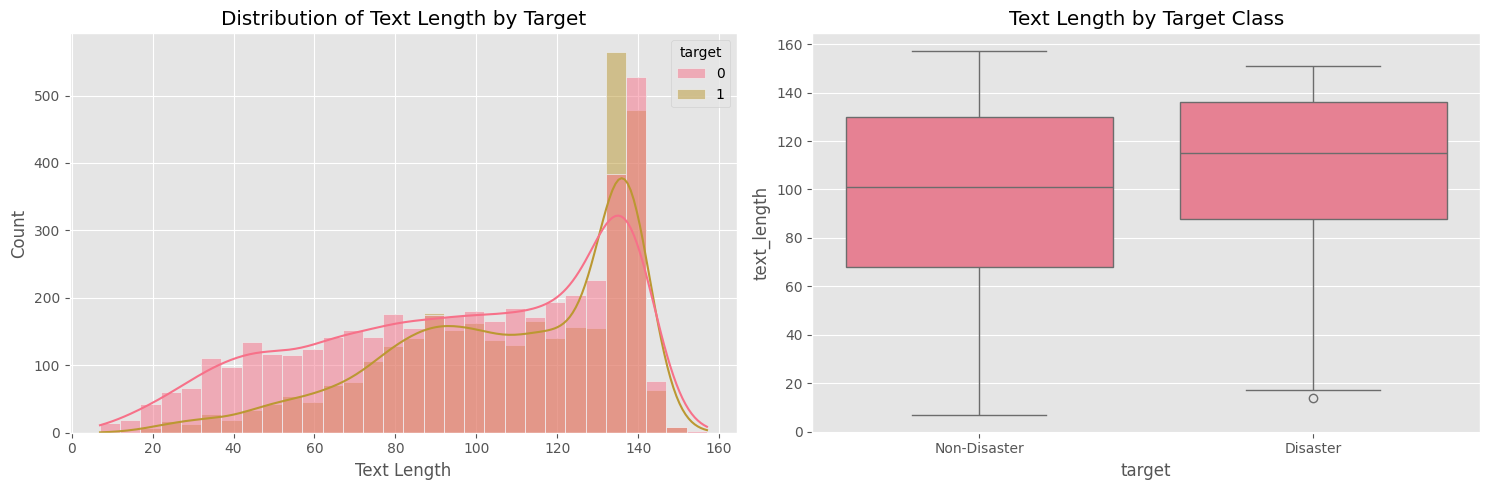

In [10]:
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='text_length', hue='target', kde=True, bins=30)
plt.title('Distribution of Text Length by Target')
plt.xlabel('Text Length')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='target', y='text_length')
plt.title('Text Length by Target Class')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

### Check keyword distribution

Top 10 keywords:
keyword
unknown        61
fatalities     45
deluge         42
armageddon     42
damage         41
body%20bags    41
harm           41
sinking        41
evacuate       40
outbreak       40
Name: count, dtype: int64


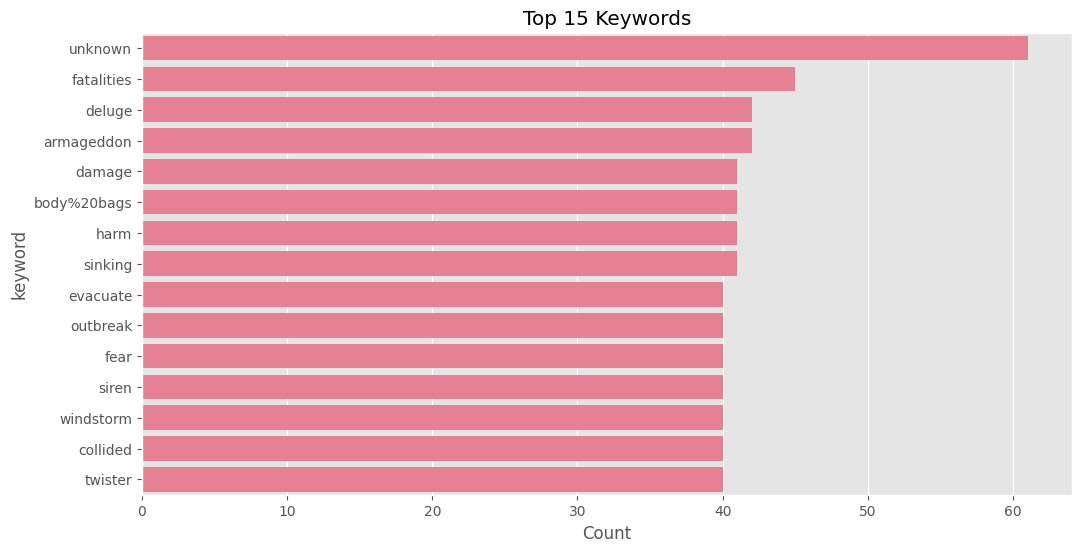

In [11]:
print("Top 10 keywords:")
print(df['keyword'].value_counts().head(10))

plt.figure(figsize=(12, 6))
top_keywords = df['keyword'].value_counts().head(15)
sns.barplot(x=top_keywords.values, y=top_keywords.index)
plt.title('Top 15 Keywords')
plt.xlabel('Count')
plt.show()

### Check location distribution

In [12]:
print("Top 10 locations:")
print(df['location'].value_counts().head(10))

Top 10 locations:
location
unknown            2533
USA                 104
New York             71
United States        50
London               45
Canada               29
Nigeria              28
UK                   27
Los Angeles, CA      26
India                24
Name: count, dtype: int64


### Analyze location completeness

In [13]:
location_completeness = df['location'].notnull().sum() / len(df) * 100
print(f"\nLocation completeness: {location_completeness:.2f}%")


Location completeness: 100.00%


## 2. Data Preparation

### Text cleaning function

In [14]:
def clean_text(text):
    # Convert to string if not already
    text = str(text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags (keep the text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Display before and after cleaning
print("Original text:", df['text'].iloc[0])
print("Cleaned text:", df['cleaned_text'].iloc[0])

Original text: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Cleaned text: our deeds are the reason of this earthquake may allah forgive us all


### Tokenization and stopword removal

In [18]:
stop_words = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return tokens

df['tokens'] = df['cleaned_text'].apply(tokenize_text)

print("Tokens:", df['tokens'].iloc[0])

Tokens: ['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive']


### Stemming and Lemmatization

In [19]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['stemmed_tokens'] = df['tokens'].apply(stem_tokens)
df['lemmatized_tokens'] = df['tokens'].apply(lemmatize_tokens)

# Convert tokens back to text for vectorization
df['processed_text'] = df['lemmatized_tokens'].apply(lambda x: ' '.join(x))

### Prepare the data for modeling

In [20]:
X = df['processed_text']
y = df['target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 6090
Test set size: 1523


## 3. Feature Engineering and Model Selection

### TF-IDF Vectorization

In [21]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF features shape: {X_train_tfidf.shape}")

TF-IDF features shape: (6090, 5000)


### Count Vectorization

In [22]:
count_vectorizer = CountVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

print(f"Count features shape: {X_train_count.shape}")

Count features shape: (6090, 5000)


### Additional feature: Text length

In [23]:
X_train_length = X_train.apply(len).values.reshape(-1, 1)
X_test_length = X_test.apply(len).values.reshape(-1, 1)

### Additional feature: Word count

In [24]:
X_train_word_count = X_train.apply(lambda x: len(x.split())).values.reshape(-1, 1)
X_test_word_count = X_test.apply(lambda x: len(x.split())).values.reshape(-1, 1)

### Combine features (example with TF-IDF + length features)

In [25]:
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf, X_train_length, X_train_word_count])
X_test_combined = hstack([X_test_tfidf, X_test_length, X_test_word_count])

print(f"Combined features shape: {X_train_combined.shape}")

Combined features shape: (6090, 5002)


### Model Selection and Training

In [26]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Multinomial Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True)
}

### Evaluate models with cross-validation

In [27]:
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_tfidf, y_train, cv=5, scoring='f1')
    results[name] = cv_scores
    print(f"{name}: F1 Score = {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

Logistic Regression: F1 Score = 0.7272 (+/- 0.0352)
Multinomial Naive Bayes: F1 Score = 0.7253 (+/- 0.0314)
Random Forest: F1 Score = 0.7108 (+/- 0.0228)
SVM: F1 Score = 0.7177 (+/- 0.0354)


### Visualize cross-validation results

([0, 1, 2, 3],
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'Multinomial Naive Bayes'),
  Text(2, 0, 'Random Forest'),
  Text(3, 0, 'SVM')])

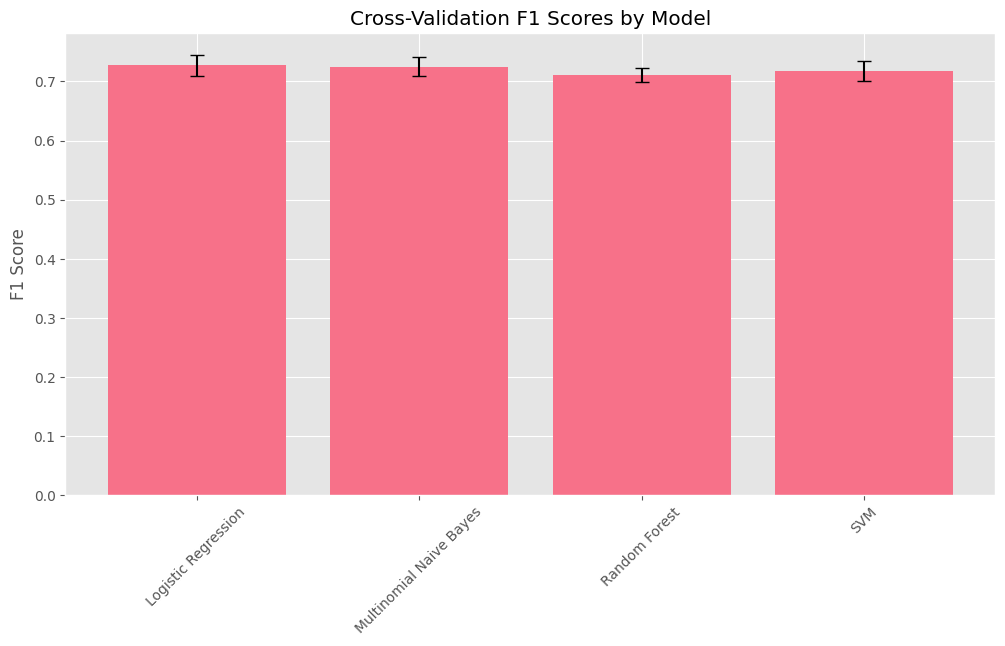

In [28]:
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
f1_scores = [np.mean(scores) for scores in results.values()]
std_devs = [np.std(scores) for scores in results.values()]

bars = plt.bar(model_names, f1_scores, yerr=std_devs, capsize=5)
plt.title('Cross-Validation F1 Scores by Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Hyperparameter tuning for the best model (Logistic Regression)

In [29]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(
    LogisticRegression(random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_search.fit(X_train_tfidf, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train_tfidf, y_train)

Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.7264791642688796


LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear')

## 4. Model Evaluation and Validation

### Make predictions

In [30]:
y_pred = best_model.predict(X_test_tfidf)
y_pred_proba = best_model.predict_proba(X_test_tfidf)[:, 1]

### Calculate evaluation metrics

In [31]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Model Evaluation Metrics:
Accuracy: 0.8168
Precision: 0.8440
Recall: 0.7034
F1 Score: 0.7673


### Confusion Matrix

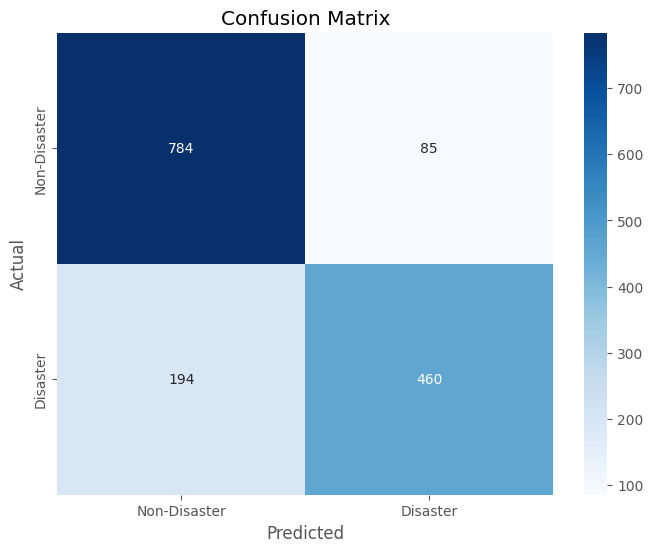

In [32]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Disaster', 'Disaster'],
            yticklabels=['Non-Disaster', 'Disaster'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### ROC Curve

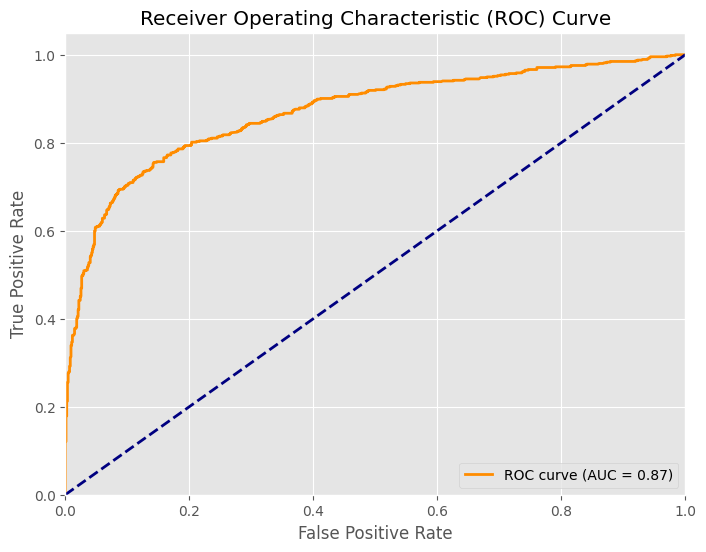

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall Curve

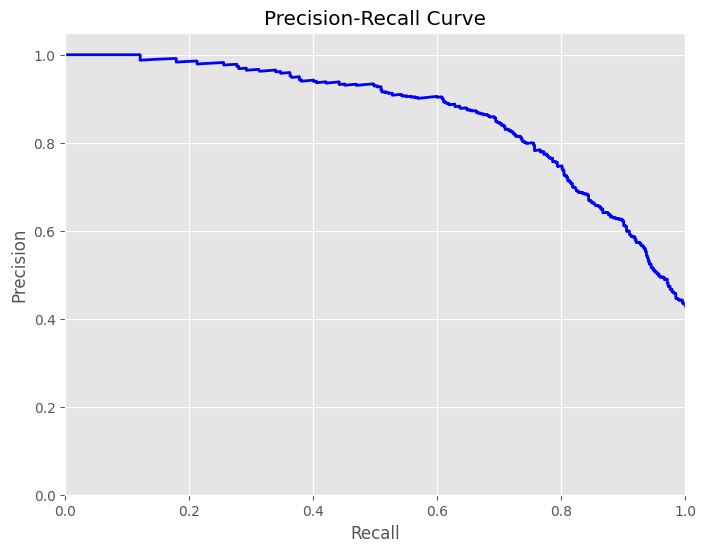

In [34]:
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

### Classification report

In [35]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Non-Disaster', 'Disaster']))

Classification Report:
              precision    recall  f1-score   support

Non-Disaster       0.80      0.90      0.85       869
    Disaster       0.84      0.70      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



### Model Validation

In [36]:
test_results = pd.DataFrame({
    'text': X_test,
    'actual': y_test,
    'predicted': y_pred,
    'probability': y_pred_proba
})

misclassified = test_results[test_results['actual'] != test_results['predicted']]
print(f"Number of misclassified tweets: {len(misclassified)}")

Number of misclassified tweets: 279


### Display some misclassified examples

In [37]:
print("\nSome misclassified examples:")
for i, row in misclassified.head(5).iterrows():
    print(f"Text: {row['text'][:100]}...")
    print(f"Actual: {row['actual']}, Predicted: {row['predicted']}, Probability: {row['probability']:.4f}")
    print("-" * 50)


Some misclassified examples:
Text: step one get mass murderer portrait yuan...
Actual: 0, Predicted: 1, Probability: 0.7053
--------------------------------------------------
Text: hollywood movie trapped miner released chile hollywood movie trapped miner starring...
Actual: 1, Predicted: 0, Probability: 0.2254
--------------------------------------------------
Text: thu aug gmt utc millcityio theramin siren...
Actual: 1, Predicted: 0, Probability: 0.4799
--------------------------------------------------
Text: cant drown demon know swim...
Actual: 1, Predicted: 0, Probability: 0.1288
--------------------------------------------------
Text: need plant pacific cyclone season would help...
Actual: 1, Predicted: 0, Probability: 0.3776
--------------------------------------------------


### Feature importance analysis (for logistic regression)

In [38]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = best_model.coef_[0]

### Get top features for each class

In [39]:
top_features = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
}).sort_values('coefficient', ascending=False)

print("Top 10 features for disaster class:")
print(top_features.head(10))

print("\nTop 10 features for non-disaster class:")
print(top_features.tail(10))

Top 10 features for disaster class:
         feature  coefficient
1984   hiroshima     3.384310
657   california     2.947841
4822    wildfire     2.887593
1326  earthquake     2.403821
1684      forest     2.390309
4231       storm     2.387609
593     building     2.367551
1646       flood     2.349165
2271      killed     2.312561
4496       train     2.286745

Top 10 features for non-disaster class:
      feature  coefficient
4902  wrecked    -1.450248
457    bloody    -1.478291
441      blew    -1.483269
2586     make    -1.493576
303       bag    -1.565376
3693     ruin    -1.612209
4723     want    -1.750002
2963      new    -1.776910
2388      let    -1.906234
2521     love    -2.154165


### Visualize feature importance

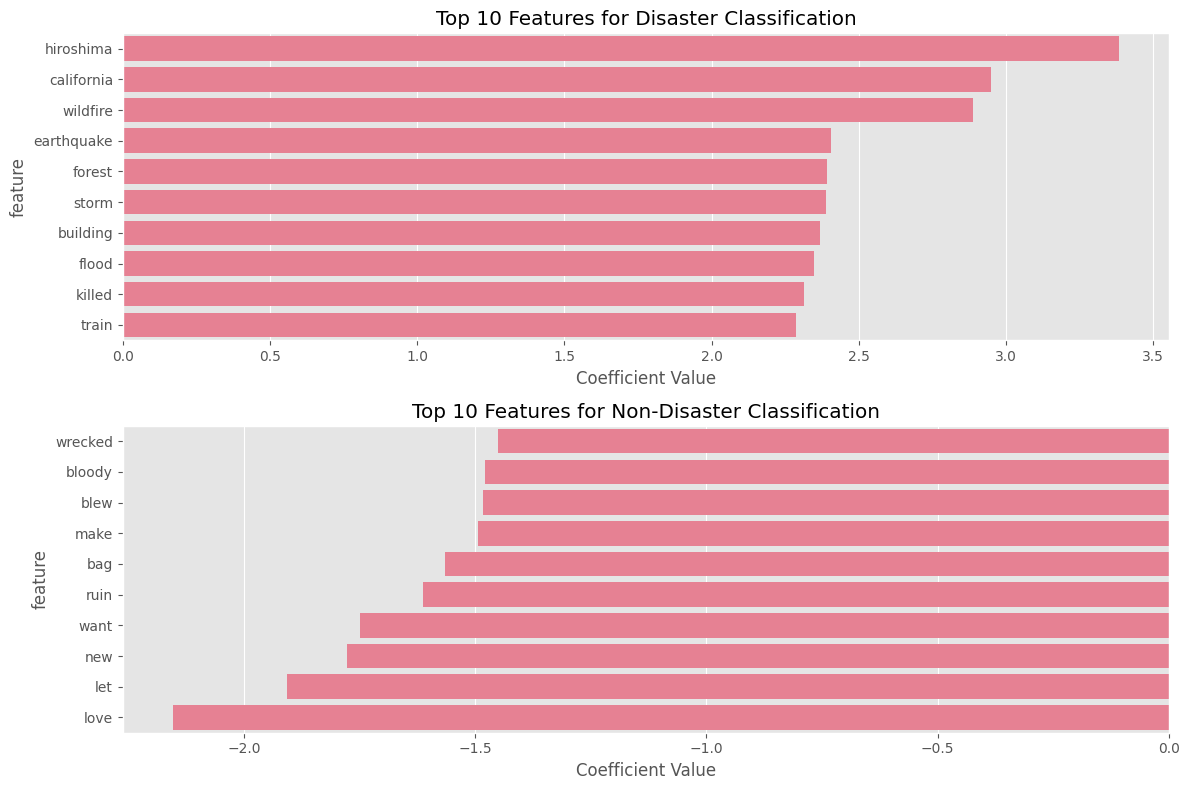

In [40]:
plt.figure(figsize=(12, 8))

top_disaster_features = top_features.head(10)
top_non_disaster_features = top_features.tail(10)

plt.subplot(2, 1, 1)
sns.barplot(x='coefficient', y='feature', data=top_disaster_features)
plt.title('Top 10 Features for Disaster Classification')
plt.xlabel('Coefficient Value')

plt.subplot(2, 1, 2)
sns.barplot(x='coefficient', y='feature', data=top_non_disaster_features)
plt.title('Top 10 Features for Non-Disaster Classification')
plt.xlabel('Coefficient Value')

plt.tight_layout()
plt.show()

## 5. Deployment with Web Interface

In [41]:
import pickle

# Save the model
with open('disaster_tweet_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("Model and vectorizer saved successfully!")

Model and vectorizer saved successfully!


### Additional EDA Plots

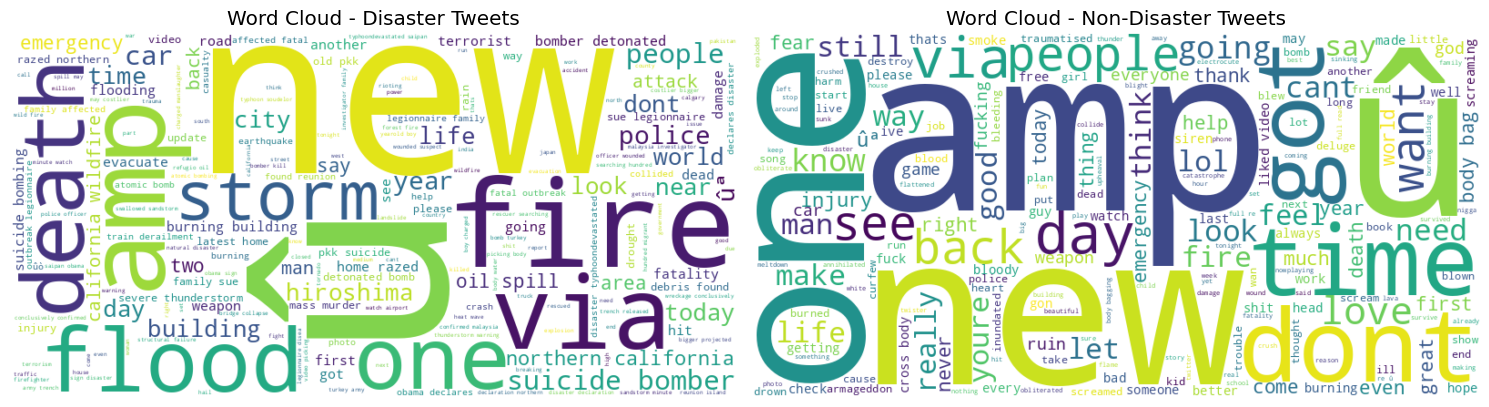

In [42]:
# Word cloud for disaster tweets
from wordcloud import WordCloud

disaster_tweets = df[df['target'] == 1]['processed_text']
non_disaster_tweets = df[df['target'] == 0]['processed_text']

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white').generate(' '.join(disaster_tweets))
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Word Cloud - Disaster Tweets')
plt.axis('off')

plt.subplot(1, 2, 2)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white').generate(' '.join(non_disaster_tweets))
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Word Cloud - Non-Disaster Tweets')
plt.axis('off')

plt.tight_layout()
plt.show()

### N-gram analysis

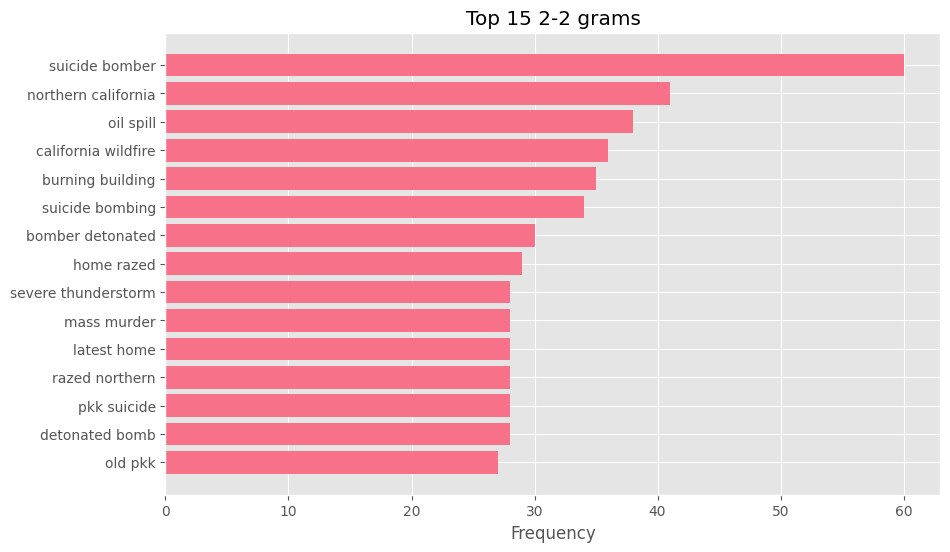

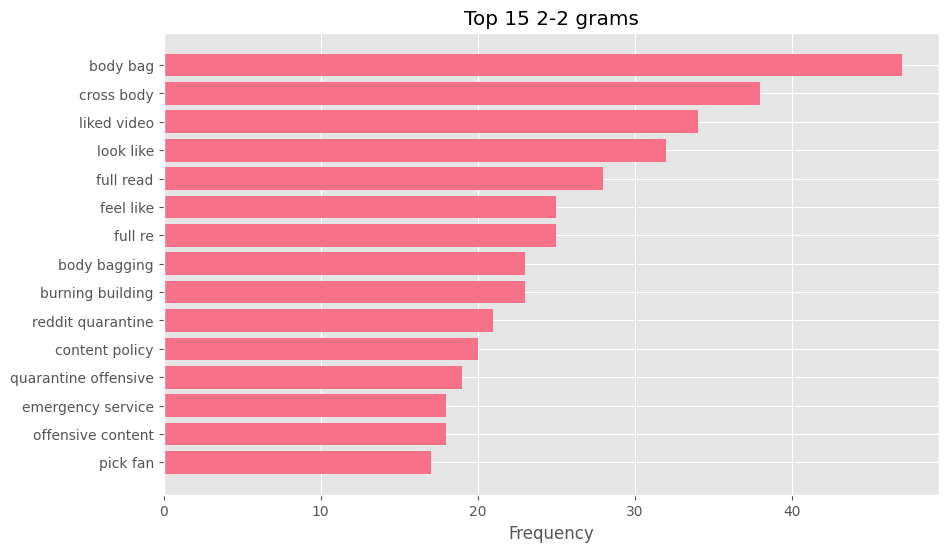

In [43]:
def plot_top_ngrams(corpus, ngram_range, n=10):
    vec = CountVectorizer(ngram_range=ngram_range, max_features=2000).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    words, frequencies = zip(*words_freq[:n])
    plt.figure(figsize=(10, 6))
    plt.barh(words, frequencies)
    plt.title(f'Top {n} {ngram_range[0]}-{ngram_range[1]} grams')
    plt.xlabel('Frequency')
    plt.gca().invert_yaxis()
    plt.show()

# Bigrams for disaster tweets
plot_top_ngrams(disaster_tweets, (2, 2), 15)

# Bigrams for non-disaster tweets
plot_top_ngrams(non_disaster_tweets, (2, 2), 15)

### Sentiment analysis

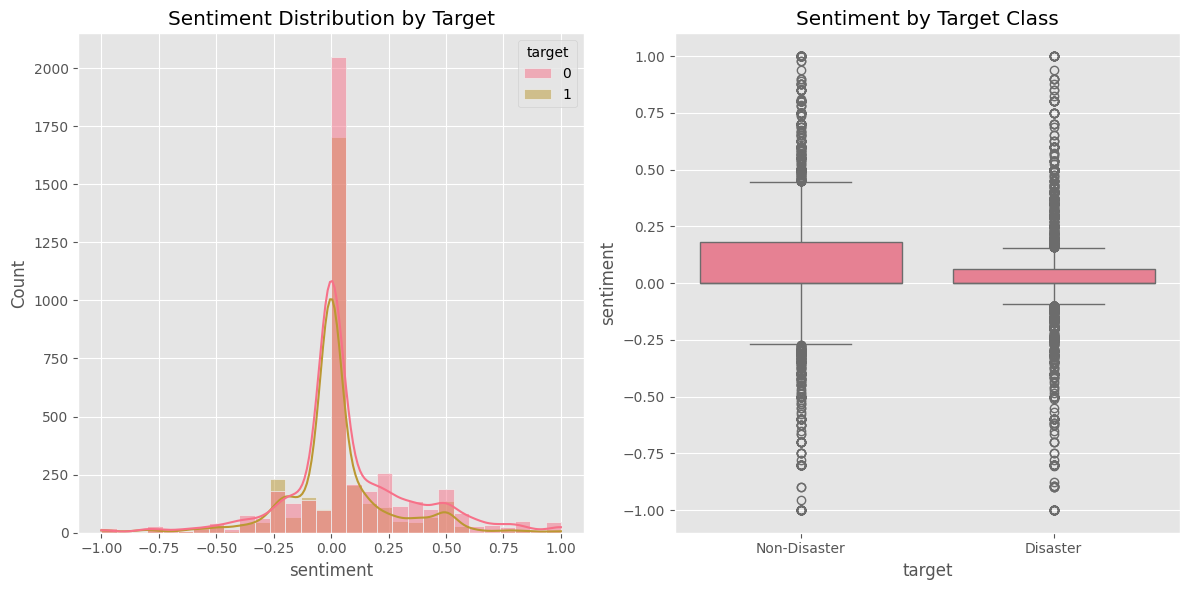

In [44]:
from textblob import TextBlob

df['sentiment'] = df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='sentiment', hue='target', kde=True, bins=30)
plt.title('Sentiment Distribution by Target')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='target', y='sentiment')
plt.title('Sentiment by Target Class')
plt.xticks([0, 1], ['Non-Disaster', 'Disaster'])

plt.tight_layout()
plt.show()